[Boltzmann.网络原帖](https://www.cnblogs.com/zyly/p/9055616.html)

一、基础概念：

受限玻尔兹曼机（Restricted Boltzmann Machine，简称RBM），是一种用于降维、分类、回归、协同过滤、特征学习和主题搭建的算法。RBM网络作为一种无监督学习的方法，其目的是尽可能地表达输入数据的的规则和特征。

二、工作原理

正向传递：

RBM是有两个层的浅层神经网络，它是组成深度置信网络的基础部件。RBM的第一个层称为可见层，又称输入层，由显元 (visible units) 组成，用于输入训练数据。第二个层是隐藏层，相应地，由隐元 (hidden units) 组成，用作特征检测器 (feature detectors)。

下图中每个圆圈都是一个与神经元相似的单元，称为节点，运算在节点中进行。一个层中的节点与另一层中的所有节点分别连接，但与同一层中的其它节点并不相连。

也就是说，**层的内部不存在通信－这就是受限玻尔兹曼机被称为受限的原因**。每个节点对输入进行处理和运算，判定是否继续传输输入的数据，**而这种判定一开始是随机的。(“随机”（stochastic）一词在此处指与输入相乘的初始系数是随机生成的。**)

每个可见节点负责处理网络需要学习的数据集中一个项目的一种低层次特征。举例来说，如果处理的是一个灰度图像的数据集，则每个可见节点将接收一张图像中每个像素的像素值。（**MNIST图像有784个像素，所以处理这类图像的神经网络的一个可见层必须有784个输入节点。**）

计算方式和MLP一样哈

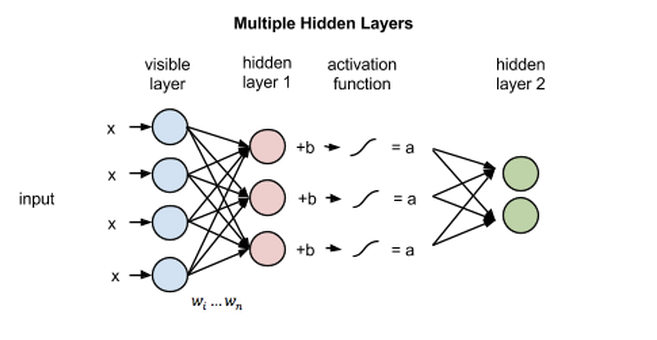

反向传递（重构）：

**第一个隐藏层的激活值成为反向传播中的输入。这些输入值与同样的权重相乘，每两个相连的节点之间各有一个权重，就像正向传播中输入x的加权运算一样。这些乘积的和再与每个可见层的偏差相加，所得结果就是重构值，**亦即原始输入的近似值，这一过程可以用下图来表示：

由于RBM的权重初始化是随机的，重构值与原始输入之间的差别通常很大。可以将r值与输入之差视为重构误差，**此误差值随后经由反向传播来修正RBM的权重，如此不断的反复，直至误差达到最小。**

概率计算：

RBM在正向传递中使用输入值来预测节点的激活值，即输入为x时输出a的概率：p(a|x:w)。 但在反向传播时，激活值成为输入，而输出的是对于原始数据的重构值，或者说猜测值，此时RBM则是在尝试估计激活值为a时输入为x的概率，激活值得加权系数与正向传播中的权重相同。第二个阶段可以表示为：p(x|a:w)。

上述两种预测值相结合，可以得到输入x和激活值a的联合概率分布，即p(x,a)。



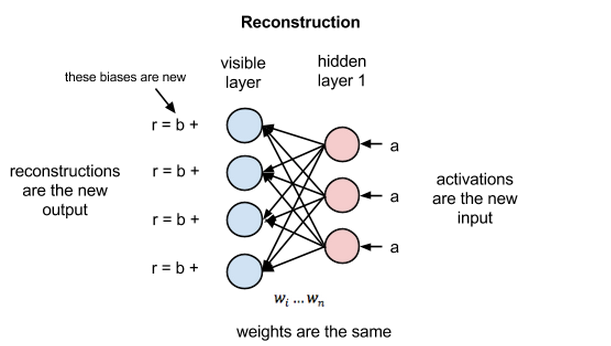

三、Python实现与应用

以MNIST数据集为例，进行训练，并打印出部分原始图像，以及重构后的图像，进行对比。程序中为了计算方便，我们的权重形状选择的是NxM，也就是之前假设的W的转置。

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 19 09:30:02 2018

@author: zy
"""

'''
受限的玻尔兹曼机:https://blog.csdn.net/zc02051126/article/details/9668439
'''
import matplotlib.pylab as plt
import numpy as np
import random


class RBM(object):
    '''
    定义一个RBM网络类
    '''
    
    def __init__(self,n_visible,n_hidden,momentum=0.5,learning_rate=0.1,max_epoch=50,batch_size=128,penalty=0,weight=None,v_bias=None,h_bias=None):
        '''
        RBM网络初始化
        
        使用动量的随机梯度下降法训练网络
        args:
            n_visible:可见层节点个数
            n_hidden：隐藏层节点个数
            momentum:动量参数 一般取值0.5,0.9,0.99  当取值0.9时，对应着最大速度1/(1-0.9)倍于梯度下降算法
            learning_rate：学习率
            max_epoch：最大训练轮数
            batch_size：小批量大小        
            penalty：规范化 权重衰减系数  一般设置为1e-4  默认不使用
            weight：权重初始化参数，默认是n_hidden x n_visible
            v_bias:可见层偏置初始化 默认是 [n_visible]
            h_bias:隐藏层偏置初始化 默认是 [n_hidden]
        '''
        #私有变量初始化
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.penalty = penalty        
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        
        if weight is None:
            self.weight = np.random.random((self.n_hidden,self.n_visible))*0.1        #用于生成一个0到0.1的随机符点数
        else:
            self.weight = weight
        if v_bias is None:
            self.v_bias = np.zeros(self.n_visible)                                    #可见层偏置
        else:
            self.v_bias = v_bias
        if h_bias is None:
            self.h_bias = np.zeros(self.n_hidden)                                     #隐藏层偏置
        else:
            self.h_bias = h_bias
                    
            
    def sigmoid(self,z):
        '''
        定义s型函数
        
        args:
            z：传入元素or list 、nparray
        '''
        return 1.0/(1.0+np.exp(-z))
    
    def forword(self,inpt):
        '''
        正向传播
        
        args:
            inpt : 输入数据(可见层) 大小为batch_size x n_visible
        '''
        z = np.dot(inpt,self.weight.T) + self.h_bias        #计算加权和
        return self.sigmoid(z)
    
    def backward(self,inpt):
        '''
        反向重构
        
        args:
            inpt : 输入数据(隐藏层) 大小为batch_size x n_hidden
        '''
        z = np.dot(inpt,self.weight) + self.v_bias    #计算加权个
        return self.sigmoid(z) 
    
    def batch(self):
        '''
        把数据集打乱，按照batch_size分组
        '''
        #获取样本个数和特征个数
        m,n = self.input_x.shape               
        
        #生成打乱的随机数
        per = list(range(m))
        random.shuffle(per)
        
        per = [per[k:k+self.batch_size] for k in range(0,m,self.batch_size)]
        
        batch_data = []
        for group in per:
            batch_data.append(self.input_x[group])        
        return batch_data

    
    def fit(self,input_x):
        '''
        开始训练网络
        
        args:
            input_x:输入数据集
        '''        
        self.input_x = input_x                                
                
        Winc = np.zeros_like(self.weight)
        binc = np.zeros_like(self.v_bias)
        cinc = np.zeros_like(self.h_bias)
        
        #开始每一轮训练
        for epoch in range(self.max_epoch):
              
            batch_data = self.batch()
            num_batchs = len(batch_data)
            
            #存放平均误差
            err_sum = 0.0            
            
            #随着迭代次数增加 penalty减小
            self.penalty = (1 - 0.9*epoch/self.max_epoch)*self.penalty
            
            
            #训练每一批次数据集
            for v0 in  batch_data:                     
                '''
                RBM网络计算过程
                '''                
                #前向传播  计算h0
                h0 = self.forword(v0)                
                h0_states = np.zeros_like(h0)                        
                #从 0, 1 均匀分布中抽取的随机值，尽然进行比较判断是开启一个隐藏节点，还是关闭一个隐藏节点
                h0_states[h0 > np.random.random(h0.shape)] = 1                
                #print('h0',h0.shape)              
                
                #反向重构  计算v1
                v1 = self.backward(h0_states)
                v1_states = np.zeros_like(v1)
                v1_states[v1 > np.random.random(v1.shape)] = 1
                #print('v1',v1.shape)
                
                #前向传播 计算h1
                h1 = self.forword(v1_states)
                h1_states = np.zeros_like(h1)                                        
                h1_states[h1 > np.random.random(h1.shape)] = 1
                #print('h1',h1.shape)
                
                
                '''更新参数 权重和偏置  使用栋梁的随机梯度下降法'''
                #计算batch_size个样本的梯度估计值
                dW = np.dot(h0_states.T , v0) - np.dot(h1_states.T , v1)
                #沿着axis=0进行合并
                db = np.sum(v0 - v1,axis=0).T
                dc = np.sum(h0 - h1,axis=0).T
            
                #计算速度更新
                Winc = self.momentum  * Winc + self.learning_rate * (dW  - self.penalty * self.weight)/self.batch_size 
                binc = self.momentum  * binc + self.learning_rate * db / self.batch_size
                cinc = self.momentum  * cinc + self.learning_rate * dc / self.batch_size
                
                #对于最大化对数似然函数  使用梯度下降法是加号 最小化是减号  开始更新
                self.weight = self.weight + Winc
                self.v_bias = self.v_bias + binc
                self.h_bias = self.h_bias + cinc
       
            
                
                err_sum = err_sum + np.mean(np.sum((v0 - v1)**2,axis=1))                        
                
            #计算平均误差
            err_sum = err_sum /num_batchs              
            print('Epoch {0},err_sum {1}'.format(epoch, err_sum))
            
    def predict(self,input_x):   
        '''
        预测重构值
        
        args:
            input_x：输入数据
        '''
        #前向传播  计算h0
        h0 = self.forword(input_x)                
        h0_states = np.zeros_like(h0)                        
        #从 0, 1 均匀分布中抽取的随机值，尽然进行比较判断是开启一个隐藏节点，还是关闭一个隐藏节点
        h0_states[h0 > np.random.random(h0.shape)] = 1                        
        
        #反向重构  计算v1
        v1 = self.backward(h0_states)
        return v1
    
    
    def visualize(self, input_x):  
        '''
        传入 形状为m xn的数据 即m表示图片的个数  n表示图像的像素个数
        
        其中 m = row x row
        n = s x s
        
        args:        
            input_x:形状为 m x n的数据
        '''        
        #获取输入样本的个数和特征数
        m, n = input_x.shape   
                
        #获取每张图像的宽和高 默认宽=高
        s = int(np.sqrt(n))          
                        
        #把所有图片以 row x row排列
        row = int(np.ceil(np.sqrt(m)))  
        
        #其中多出来的row + 1是用于绘制边框的 
        data = np.zeros((row*s + row + 1, row * s + row + 1)) - 1.0
        
        #图像在x轴索引
        x = 0  
        #图像在y轴索引
        y = 0  
        #遍历每一张图像
        for i in range(m):                 
            z = input_x[i]                  
            z = np.reshape(z,(s,s))
            #填充第i张图像数据                
            data[x*s + x + 1 :(x+1)*s + x + 1 , y*s + y + 1 :(y+1)*s + y + 1] = z  
            x = x + 1  
            #换行
            if(x >= row):  
                x = 0  
                y = y + 1                           
        return data  


def read_data(path):  
    '''
    加载数据集  数据按行分割，每一行表示一个样本，每个特征使用空格分割
    
    args:
        path：数据文件路径
    '''
    data = []  
    for line in open(path, 'r'):  
        ele = line.split(' ')  
        tmp = []  
        for e in ele:  
            if e != '':  
                tmp.append(float(e.strip(' ')))  
        data.append(tmp)  
    return data  

(5000, 784)
Epoch 0,err_sum 107.8152068597232
Epoch 1,err_sum 48.67078925799702
Epoch 2,err_sum 41.103520374036265
Epoch 3,err_sum 35.88104101275952
Epoch 4,err_sum 32.67377777511378
Epoch 5,err_sum 30.54136117594107
Epoch 6,err_sum 28.99198910292671
Epoch 7,err_sum 27.62358717146397
Epoch 8,err_sum 26.55369348021076
Epoch 9,err_sum 25.871370270971546
Epoch 10,err_sum 24.90084709547255
Epoch 11,err_sum 24.352235746212845
Epoch 12,err_sum 23.81327521915454
Epoch 13,err_sum 23.2046000277947
Epoch 14,err_sum 22.684581572866072
Epoch 15,err_sum 22.199014105549573
Epoch 16,err_sum 21.87708346797266
Epoch 17,err_sum 21.536664613782207
Epoch 18,err_sum 21.228837534704983
Epoch 19,err_sum 20.83802432435319
Epoch 20,err_sum 20.664619445792393
Epoch 21,err_sum 20.519479873446794
Epoch 22,err_sum 20.108376100258642
Epoch 23,err_sum 19.831861885811115
Epoch 24,err_sum 19.63292868079947
Epoch 25,err_sum 19.58682343889945
Epoch 26,err_sum 19.311194135485355
Epoch 27,err_sum 19.11389418889692
Epoch 2

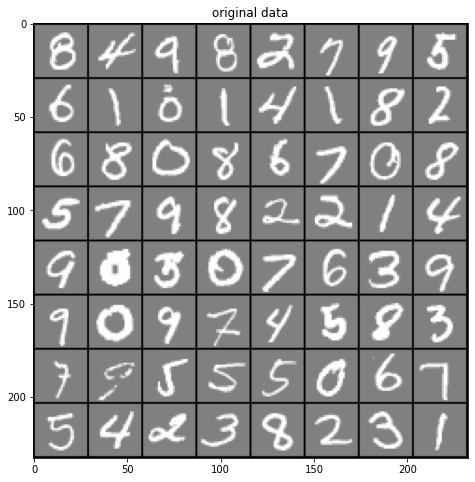

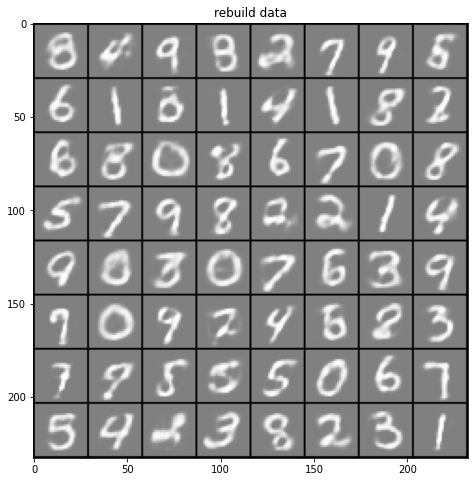

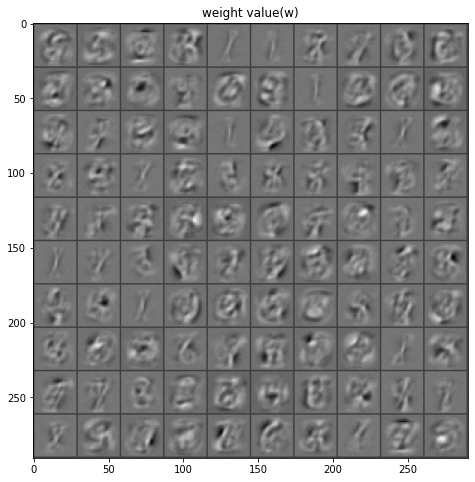

In [10]:
if __name__ == '__main__':  
    #加载MNIST数据集 总共有5000张图像，每张图像有784个像素点   MNIST数据集可以从网上下载
    data = read_data('data.txt')  
    data = np.array(data)  
    print(data.shape)                  #(5000, 784)    
    
    #创建RBM网络
    rbm = RBM(784, 100,max_epoch = 50,learning_rate=0.05)  
    #开始训练
    rbm.fit(data)  


    #显示64张手写数字 
    images = data[0:64]
    print(images.shape)
    a = rbm.visualize(images)
    fig = plt.figure(1,figsize=(8,8))      
    plt.imshow(a,cmap=plt.cm.gray)  
    plt.title('original data')      
      
    #显示重构的图像
    rebuild_value = rbm.predict(images)
    b = rbm.visualize(rebuild_value)  
    fig = plt.figure(2,figsize=(8,8))      
    plt.imshow(b,cmap=plt.cm.gray)  
    plt.title('rebuild data')  
      
    
    #显示权重
    w_value = rbm.weight  
    c = rbm.visualize(w_value)  
    fig = plt.figure(3,figsize=(8,8))    
    plt.imshow(c,cmap=plt.cm.gray)  
    plt.title('weight value(w)')  
    plt.show()                          

对minist数据集做多分类，以上分别为50轮训练后的原图，重构（预测图）及最终权重。权重满足数字的大致轮廓。肯定，因为和轮廓贴切才能使最终值最大